Qiitaの記事 [AIは青春小説の甘酸っぱさを可視化できるのか？](https://qiita.com/izaki_shin/items/265166c8dd3a39e7e44a) のコードです。

夏目漱石の代表作の一つ「三四郎」に感情分析を適用し、  
青春小説の甘酸っぱさを可視化できるのか、試してきます。


## 0. 前準備: Matplotlibで日本語フォントを使用できるようにする

In [ ]:
# [前準備] Matplotlib で日本語フォントを使用できるようにする
# cf. https://blog.3qe.us/entry/2018/08/16/121457
!apt-get -y install fonts-ipafont-gothic
!rm /root/.cache/matplotlib/fontlist-v310.json

# NOTE ここで、ランタイムを再起動

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 40 not upgraded.
Need to get 8,251 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-gothic all 00303-18ubuntu1 [3,526 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-mincho all 00303-18ubuntu1 [4,725 kB]
Fetched 8,251 kB in 0s (40.1 MB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 155501 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-18ubuntu1_all.deb ...
Unpacking fonts-ipafont-gothic (00303-18ubuntu1) ...
Selecting previously unselected package fonts-ipa

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')

## 1. 青空文庫から「三四郎」をダウンロードする
cf. https://qiita.com/makaishi2/items/63b7986f6da93dc55edd

In [ ]:
# zipファイルダウンロード
url = 'https://www.aozora.gr.jp/cards/000148/files/794_ruby_4237.zip'
zip = '794_ruby_4237.zip'
import urllib.request
urllib.request.urlretrieve(url, zip)

# ダウンロードしたzipの解凍
import zipfile
with zipfile.ZipFile(zip, 'r') as myzip:
    myzip.extractall()
    # 解凍後のファイルからデータ読み込み
    for myfile in myzip.infolist():
        # 解凍後ファイル名取得
        filename = myfile.filename
        # ファイルオープン時にencodingを指定してsjisの変換をする
        with open(filename, encoding='sjis') as file:
            text = file.read()

# ファイル整形
import re
# ヘッダ部分の除去
text = re.split('\-{5,}',text)[2]
# フッタ部分の除去
text = re.split('底本：',text)[0]
# | の除去
text = text.replace('|', '')
# ルビの削除
text = re.sub('《.+?》', '', text)
# 入力注の削除
text = re.sub('［＃.+?］', '',text)
# 空行の削除
text = re.sub('\n\n', '\n', text) 
text = re.sub('\r', '', text)
# 全角スペースを削除する
text = re.sub(r'\u3000', '', text)
# 「。」で改行する
text = re.sub('。', '。\n', text) 
text = re.sub('\n\n', '\n', text) 

In [ ]:
# 一文ずつに区切る　（ "。\n" で区切る）
sentences = text.split('\n')

print(len(sentences))
print(sentences[:10])

6976
['', '一', 'うとうととして目がさめると女はいつのまにか、隣のじいさんと話を始めている。', 'このじいさんはたしかに前の前の駅から乗ったいなか者である。', '発車まぎわに頓狂な声を出して駆け込んで来て、いきなり肌をぬいだと思ったら背中にお灸のあとがいっぱいあったので、三四郎の記憶に残っている。', 'じいさんが汗をふいて、肌を入れて、女の隣に腰をかけたまでよく注意して見ていたくらいである。', '女とは京都からの相乗りである。', '乗った時から三四郎の目についた。', '第一色が黒い。', '三四郎は九州から山陽線に移って、だんだん京大阪へ近づいて来るうちに、女の色が次第に白くなるのでいつのまにか故郷を遠のくような哀れを感じていた。']


In [ ]:
# 章ごとに分析するための準備
chapter_start_idxs = []

kanji_nums = set(['一', '二', '三', '四', '五', '六', '七', '八', '九', '〇'])
for i, sent in enumerate(sentences):
    # 文字数が1or2　かつ 漢数字のみ
    if len(sent) in (1, 2) and set(sent) < set(kanji_nums):
        print(i, sent)
        chapter_start_idxs.append(i)

def get_chapter_id(sent_idx):
    """文番号から章番号を取得する."""
    for i, sidx in enumerate(chapter_start_idxs[::-1]):
        if sent_idx >= sidx:
            return len(chapter_start_idxs) - i

1 一
426 二
753 三
1455 四
2430 五
2996 六
3783 七
4171 八
4857 九
5380 一〇
5882 一一
6358 一二
6898 一三


## 2. ML-Askで感情分析して、DataFrameに格納

### 2.1 ML-Askをインストール

In [ ]:
! pip install pymlask
! apt install aptitude
! aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
! pip install mecab-python3==0.7

     |████████████████████████████████| 70 kB 5.4 MB/s 
  Created wheel for pymlask: filename=pymlask-0.3.2-py3-none-any.whl size=74906 sha256=33c9ccf6784ee2dfa466aa3ee4691fc2d4d95f571bf7b4a39705897d87229274
  Stored in directory: /root/.cache/pip/wheels/28/a8/2b/a4e4b83dc2ee2d492f49a8ad59325fff4d3540254a5a4ac560
Successfully built pymlask
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template

### 2.2 試しに分析してみる

In [ ]:
from mlask import MLAsk
emotion_analyzer = MLAsk()

# 試しに使用してみる
emotion_analyzer.analyze("美禰子と三四郎は声を出して笑った。")

{'activation': 'NEUTRAL',
 'emoticon': None,
 'emotion': defaultdict(list, {'yorokobi': ['笑う']}),
 'intensifier': {},
 'intension': 0,
 'orientation': 'POSITIVE',
 'representative': ('yorokobi', ['笑う']),
 'text': '美禰子と三四郎は声を出して笑った。'}

### 2.3 一文ずつ感情分析を適用する

In [ ]:
import pandas as pd

data_list = []
for sent_idx, sentence in enumerate(sentences):
    res = emotion_analyzer.analyze(sentence)
    if res['emotion'] is not None:  # 感情表現を含む場合のみ
        data_list.append([
            sent_idx,
            get_chapter_id(sent_idx),  # 文番号から章番号を算出する自作関数
            res['representative'][0],  # 主たる感情
            res['activation'],         # ラッセルの円環モデルの「覚醒」
            res['orientation'],        # ラッセルの円環モデルの「快」
            res['text']                # 分析対象の文
        ])
df_emo = pd.DataFrame(data_list, columns=['sentence_id', 'chapter_id', 'emotion', 'activation', 'orientation', 'text'])

df_emo.head()

,sentence_id,chapter_id,emotion,activation,orientation,text
0,9,1,aware,PASSIVE,NEGATIVE,三四郎は九州から山陽線に移って、だんだん京大阪へ近づいて来るうちに、女の色が次第に白くなるの...
1,14,1,yorokobi,NEUTRAL,POSITIVE,そばを離れるのが大いにありがたかった。
2,20,1,yorokobi,NEUTRAL,POSITIVE,なんとなくいい心持ちにできあがっている。
3,24,1,yorokobi,NEUTRAL,POSITIVE,その時女はにこりと笑って、さあおかけと言ってじいさんに席を譲っていた。
4,26,1,suki,NEUTRAL,POSITIVE,その寝ているあいだに女とじいさんは懇意になって話を始めたものとみえる。


## 3. 感情の起伏を可視化する

全13章の章ごとに、感情分析の結果（`'representative'`）を集計します。  
集計方法は、シンプルに、各感情の出現回数をカウントしてみます。  
（章ごとの文章数が異なるので、正規化はします。）

In [ ]:
# 各章の文章数をカウント
chapter_num = len(chapter_start_idxs)

chapter_sent_nums = [chapter_start_idxs[i+1] - chapter_start_idxs[i] for i in range(0, chapter_num-1)]
chapter_sent_nums.append(len(sentences) - chapter_start_idxs[chapter_num-1])
print(chapter_sent_nums)

[425, 327, 702, 975, 566, 787, 388, 686, 523, 502, 476, 540, 78]


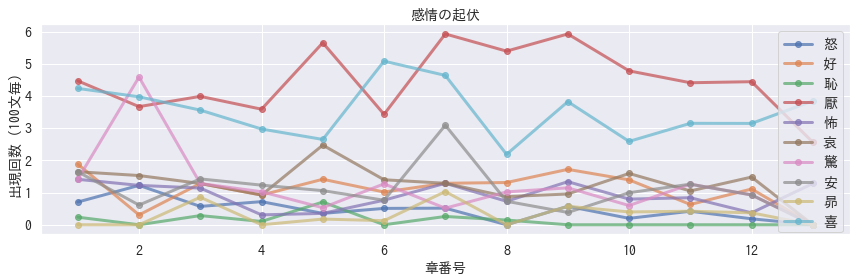

In [ ]:
# 感情ラベル 10種
emotion_labels = {'ikari': '怒', 'suki': '好', 'haji': '恥', 'iya': '厭', 'kowa': '怖', 'aware': '哀', 'odoroki': '驚', 'yasu': '安', 'takaburi': '昴', 'yorokobi': '喜'}

chapter_ids = range(1, chapter_num+1)

plt.figure(figsize=(12, 4))
fontsize = 14
linewidth = 3

for label, label_jp in emotion_labels.items():
    # 対象の感情の出現回数を、章ごとにカウント
    df_target = df_emo[df_emo.emotion == label]
    cnts = [(df_target.chapter_id == ci).sum() for ci in chapter_ids]
    # 各章の文章数で正規化
    cnts_norm = [cnts[ci-1] / chapter_sent_nums[ci-1] * 100 for ci in chapter_ids]
    plt.plot(chapter_ids, cnts_norm, 'o-', label=label_jp, linewidth=linewidth, alpha=0.7)

plt.xlabel('章番号', fontsize=fontsize)
plt.ylabel('出現回数（100文毎）', fontsize=fontsize)
plt.title('感情の起伏', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.tight_layout()

### 3.2 ラッセルの円環モデルも見てみる

In [ ]:
# 今回は簡単のため、mostly_* は * に変換
df_emo = df_emo.replace({f'mostly_{s}': s for s in ('POSITIVE', 'NEGATIVE', 'ACTIVE', 'PASSIVE')})

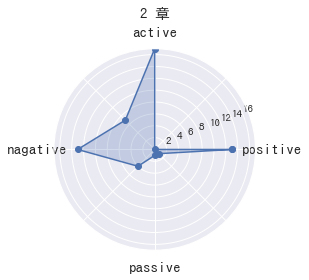

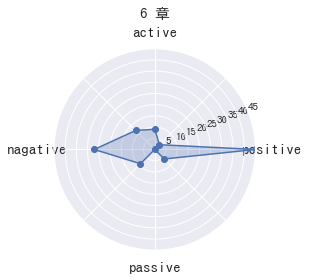

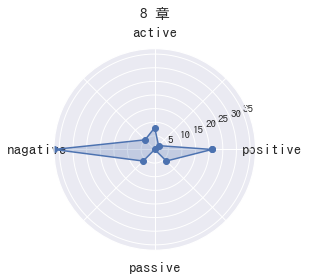

In [ ]:
import numpy as np

def plot_polar(labels, values, title):
    """レーダーチャートを描画する.
    cf. https://qiita.com/e10persona/items/7a7643b266c2bdfbf7d0
    """
    angles = np.linspace(0, 2 * np.pi, len(labels) + 1, endpoint=True)
    values = np.concatenate((values, [values[0]]))  # 閉じた多角形にする
    fig = plt.figure(tight_layout=True)
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, values, 'o-')  # 外枠
    ax.fill(angles, values, alpha=0.25)  # 塗りつぶし
    ax.set_thetagrids(angles[:-1] * 180 / np.pi, labels, fontsize=15)  # 軸ラベル
    ax.set_rlim(0 ,max(values))
    ax.set_title(title, fontsize=15)

def draw_russell_circumplex(chapter_id):
    """ラッセルの円環モデルを、レーダーチャートで描画."""
    df_target = df_emo[df_emo.chapter_id == chapter_id]

    sets = (
        ('POSITIVE', 'NEUTRAL'),
        ('POSITIVE', 'ACTIVE'),
        ('NEUTRAL', 'ACTIVE'),
        ('NEGATIVE', 'ACTIVE'),
        ('NEGATIVE', 'NEUTRAL'),
        ('NEGATIVE', 'PASSIVE'),
        ('NEUTRAL', 'PASSIVE'),
        ('POSITIVE', 'PASSIVE'),
    )
    labels = ('positive', '', 'active', '', 'nagative', '', 'passive', '')

    values = [0] * 8
    for ori_act in df_target[['orientation', 'activation']].values:
        if tuple(ori_act) == ('NEUTRAL', 'NEUTRAL'):  # 今回は無視
            continue
        values[sets.index(tuple(ori_act))] += 1

    plot_polar(labels, values, f'{chapter_id} 章\n')

# 描画 （2章、6章、8章）
draw_russell_circumplex(chapter_id=2)
draw_russell_circumplex(chapter_id=6)
draw_russell_circumplex(chapter_id=8)

In [ ]:
# 実際の文章を抽出してみる
df_emo[(df_emo.chapter_id == 6) & (df_emo.emotion == 'yorokobi')]

,sentence_id,chapter_id,emotion,activation,orientation,text
444,3007,6,yorokobi,NEUTRAL,POSITIVE,カントの超絶唯心論がバークレーの超絶実在論にどうだとか言ったな」
446,3034,6,yorokobi,NEUTRAL,POSITIVE,向こうに立っていた一人の学生が、この様子を見てにやにや笑い出した。
449,3051,6,yorokobi,NEUTRAL,POSITIVE,三四郎は微笑わざるをえなかった。
461,3121,6,yorokobi,NEUTRAL,POSITIVE,なんとなく得意である。
462,3123,6,yorokobi,NEUTRAL,POSITIVE,下宿へ帰って、湯にはいって、いい心持ちになって上がってみると、机の上に絵はがきがある。
465,3129,6,yorokobi,NEUTRAL,NEUTRAL,のみならず、はがきの裏に、迷える子を二匹書いて、その一匹をあんに自分に見立ててくれたのをはな...
470,3144,6,yorokobi,NEUTRAL,POSITIVE,じつはふわふわして読みだしたのであるが、二、三ページくると、次第に釣り込まれるように気が乗っ...
472,3163,6,yorokobi,NEUTRAL,POSITIVE,よく考えてみると、与次郎の論文には活気がある。
474,3168,6,yorokobi,NEUTRAL,POSITIVE,いなか者の三四郎にはてっきりそこと気取ることはできなかったが、ただ読んだあとで、自分の心を探...
475,3170,6,yorokobi,NEUTRAL,POSITIVE,するとこっちのほうは万事が快感である。


## おまけ：「三四郎」が主語の文章のみを抽出する

### GiNZAのインストール

In [ ]:
# https://megagonlabs.github.io/ginza/
# 2. GiNZA + 従来型モデル
! pip install -U ginza ja_ginza

     |████████████████████████████████| 59.1 MB 1.4 MB/s 
     |████████████████████████████████| 6.0 MB 11.3 MB/s 
     |████████████████████████████████| 2.2 MB 7.1 MB/s 
     |████████████████████████████████| 181 kB 44.4 MB/s 
     |████████████████████████████████| 457 kB 40.8 MB/s 
     |████████████████████████████████| 653 kB 69.2 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 10.1 MB 37.4 MB/s 
  Created wheel for SudachiDict-core: filename=SudachiDict_core-20211220-py3-none-any.whl size=71565353 sha256=4215bf644aa0c4b7f2e9b3a23470c2a291fbaf26972aa38728ae11477aaf7fa7
  Stored in directory: /root/.cache/pip/wheels/17/6d/f6/f9451cbfc76ffdf985af12239191ca20721f1da5aba5005eb0
Successfully built SudachiDict-core
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall:

### 主語が「三四郎」の文章だけ感情分析をする

In [ ]:
import spacy
nlp = spacy.load('ja_ginza')

target_sents = []
for i, sentence in enumerate(sentences):
    doc = nlp(sentence)
    for sent in doc.sents:
        subjs = [token.lemma_ for token in sent if token.dep_ in ['nsubj', 'iobj']]
        if '三四郎' in subjs:
            target_sents.append((i, sent.text))
print(len(target_sents))

773


In [ ]:
data_list = []
for sent_idx, sentence in target_sents:
    res = emotion_analyzer.analyze(sentence)
    if res['emotion'] is not None:  # 感情表現を含む場合のみ
        data_list.append([
            sent_idx,
            get_chapter_id(sent_idx),  # 文番号から章番号を算出する自作関数
            res['representative'][0],  # 主たる感情
            res['activation'],         # ラッセルの円環モデルの「覚醒」
            res['orientation'],        # ラッセルの円環モデルの「快」
            res['text']                # 分析対象の文
        ])
df_emo_sanshiro = pd.DataFrame(data_list, columns=['sentence_id', 'chapter_id', 'emotion', 'activation', 'orientation', 'text'])

df_emo_sanshiro.head()

,sentence_id,chapter_id,emotion,activation,orientation,text
0,9,1,aware,PASSIVE,NEGATIVE,三四郎は九州から山陽線に移って、だんだん京大阪へ近づいて来るうちに、女の色が次第に白くなるの...
1,86,1,odoroki,ACTIVE,NEUTRAL,三四郎は驚いた。
2,229,1,aware,PASSIVE,NEGATIVE,三四郎はここまで来て、さらにしょげてしまった。
3,282,1,yorokobi,NEUTRAL,POSITIVE,三四郎は、かぶっている古帽子の徽章の痕が、この男の目に映ったのをうれしく感じた。
4,308,1,yasu,PASSIVE,POSITIVE,三四郎は安心して席を向こう側へ移した。


In [ ]:
df_emo_sanshiro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence_id  164 non-null    int64 
 1   chapter_id   164 non-null    int64 
 2   emotion      164 non-null    object
 3   activation   164 non-null    object
 4   orientation  164 non-null    object
 5   text         164 non-null    object
dtypes: int64(2), object(4)
memory usage: 7.8+ KB
